# Install Library

In [ ]:
# @title 1. Instalasi dan Impor Library
# Instalasi library yang dibutuhkan
!pip install scikit-multilearn --quiet
!pip install sastrawi --quiet


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


# Import Library

In [2]:
# Impor library
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import random
import pickle
from wordcloud import WordCloud

# Sastrawi & Stopwords
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# TensorFlow dan Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

# Scikit-learn, Scikit-multilearn 
from skmultilearn.model_selection import iterative_train_test_split
from skmultilearn.model_selection import IterativeStratification, iterative_train_test_split
from sklearn.metrics import (
    accuracy_score,
    hamming_loss,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    multilabel_confusion_matrix
)

# Mengatur environment
tqdm.pandas()
import warnings
warnings.filterwarnings("ignore")

/Users/chairaloctavyanz/.pyenv/versions/3.10.12/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load, Prepro, Initialization Dataset

In [3]:
# @title 2. Memuat & Preprocessing Data
df = pd.read_csv('dataset_berita_multilabel2.csv')
df_sw = pd.read_csv('stopwordbahasa.csv', header=None)

# Fungsi-fungsi preprocessing
def text_lower(text): return text.lower()
def normalize_and_clean_text(text):
    text = re.sub(r'<.*?>', ' ', text); text = re.sub(r'[^a-zA-Z\s]', ' ', text); text = re.sub(r'\s+', ' ', text)
    return text.strip()

stopword_factory = StopWordRemoverFactory()
sastrawi_stopwords = set(stopword_factory.get_stop_words())
custom_stopwords = set(df_sw[0])
all_stopwords = sastrawi_stopwords.union(custom_stopwords)

def remove_stopwords(text, stopwords_set):
    words = text.split()
    return " ".join([word for word in words if word not in stopwords_set])

print("Memulai proses preprocessing teks...")
df['cleaned_konten'] = df['konten'].astype(str).progress_apply(text_lower)
df['cleaned_konten'] = df['cleaned_konten'].progress_apply(normalize_and_clean_text)
df['cleaned_konten'] = df['cleaned_konten'].progress_apply(lambda x: remove_stopwords(x, all_stopwords))
print("Preprocessing teks selesai.")

# --- Menyiapkan Fitur (X) dan Label (Y) untuk Multilabel ---
labels = ['hukum', 'politik', 'ekonomi']
X = df['cleaned_konten'].values
y = df[labels].values

print(f"\nBentuk data fitur (X): {X.shape}")
print(f"Bentuk data label (y): {y.shape}\n\n")

df.head()

Memulai proses preprocessing teks...


100%|██████████| 968/968 [00:00<00:00, 449821.21it/s]

Preprocessing teks selesai.

Bentuk data fitur (X): (968,)
Bentuk data label (y): (968, 3)




,tanggal,sumber (url),judul berita,konten,politik,hukum,ekonomi,jumlah label,cleaned_konten
0,2025-04-24,https://news.detik.com/kolom/d-7883182/kualita...,"Kualitas Ketertiban Umum Memburuk, Penegak Huk...",Premanisme yang terus merajalela akhir-akhir i...,0,0,0,0,premanisme merajalela cerita fakta memburuknya...
1,2025-01-17,https://news.detik.com/pilkada/d-7737155/jeje-...,Jeje Govinda Tepis Tudingan Hengky Kurniawan s...,KPU Kabupaten Bandung Barat dan pihak Cabup-Ca...,1,0,0,2,kpu kabupaten bandung barat cabup cawabup band...
2,2024-09-05,https://news.detik.com/berita/d-7526786/pengac...,Pengacara Klaim Alasan Alice Guo ke Indonesia ...,Mantan Wali Kota Bamban di Filipina yang juga ...,0,0,0,0,mantan wali kota bamban filipina buron pencuci...
3,2025-05-21,https://news.detik.com/berita/d-7924924/kejagu...,Kejagung Segera Tentukan Status Hukum Bos Sritex,Kejaksaan Agung (Kejagung) mengamankan eks Dir...,0,1,0,4,kejaksaan agung kejagung mengamankan eks direk...
4,2025-03-22,https://news.detik.com/foto-news/d-7835198/bin...,Bingkai Sepekan: Aksi Tolak RUU TNI hingga Tim...,Jakarta - Isu politik hingga sepakbola jadi pe...,1,0,0,2,jakarta isu politik sepakbola perbincangan han...


# Data Spliting

In [4]:
# @title 3. Pembagian Data (Iterative Stratified Split untuk Multilabel)
# Menggunakan iterative_train_test_split untuk menjaga proporsi kombinasi label
print("Membagi data menjadi data latih dan uji (80:20) menggunakan iterative split...")
X_train, y_train, X_test, y_test = iterative_train_test_split(X.reshape(-1, 1), y, test_size=0.2)

# Mengembalikan X_train dan X_test ke bentuk 1D array
X_train = X_train.ravel()
X_test = X_test.ravel()

print(f"\nJumlah data latih awal: {len(X_train)}")
print(f"Jumlah data uji: {len(X_test)}")

# ========================== REUSABLE ==========================
# Mengubah vektor label menjadi string
y_train_str = np.array(['-'.join(map(str, row)) for row in y_train])
# ========================== REUSABLE ==========================

# Hitung frekuensi masing-masing kombinasi
y_train_str_counts = pd.Series(y_train_str).value_counts()

# Menampilkan Distribusi
print("\nDistribusi label pada data latih:")
print(pd.DataFrame(y_train, columns=labels).sum())

print("\nDistribusi Kombinasi label:")
print(y_train_str_counts)



Membagi data menjadi data latih dan uji (80:20) menggunakan iterative split...

Jumlah data latih awal: 774
Jumlah data uji: 194

Distribusi label pada data latih:
hukum      200
politik    463
ekonomi    167
dtype: int64

Distribusi Kombinasi label:
0-1-0    295
0-0-0    154
1-0-0     91
0-1-1     67
1-1-0     67
0-0-1     58
1-1-1     34
1-0-1      8
Name: count, dtype: int64


# Tokenization & Padding

In [5]:
# @title 5. Tokenisasi dan Padding
VOCAB_SIZE = 5000
MAX_LEN = 200

tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post', truncating='post')

In [6]:
!pip install iterative-stratification


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [7]:
# 1. Pastikan library yang dibutuhkan sudah terinstal
# pip install tensorflow scikit-learn iterative-stratify numpy



# Asumsikan variabel-variabel ini sudah didefinisikan sebelumnya dari kode Anda:
# VOCAB_SIZE, MAX_LEN, labels
# X_train_pad, y_train
# X_test_pad, y_test

# --- LANGKAH 2: Menggabungkan kembali data ---
# Gabungkan data training dan testing awal untuk di-split ulang oleh K-Fold
X_combined = np.concatenate((X_train_pad, X_test_pad), axis=0)
y_combined = np.concatenate((y_train, y_test), axis=0)


# --- LANGKAH 3: Inisialisasi K-Fold ---
# Gunakan MultilabelStratifiedKFold untuk menjaga distribusi label
mskf = MultilabelStratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# List untuk menyimpan skor dari setiap fold
fold_histories = []
fold_no = 1

# --- LANGKAH 4: Membuat Loop K-Fold ---
for train_index, val_index in mskf.split(X_combined, y_combined):
    print(f"--- Melatih Fold ke-{fold_no} ---")

    # Membagi data untuk fold saat ini
    X_train_fold, X_val = X_combined[train_index], X_combined[val_index]
    y_train_fold, y_val = y_combined[train_index], y_combined[val_index]

    # --- LANGKAH 5: Membangun Ulang Model di Setiap Fold ---
    # Model harus didefinisikan di dalam loop untuk me-reset bobot di setiap iterasi
    def create_model():
        model = Sequential([
            Embedding(input_dim=VOCAB_SIZE, output_dim=128, input_length=MAX_LEN),
            Bidirectional(LSTM(64, return_sequences=True)),
            Dropout(0.4),
            Bidirectional(LSTM(64)),
            Dropout(0.4),
            Dense(len(labels), activation='sigmoid')
        ])

        model.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        return model

    model_kfold = create_model()
    # model_kfold.summary() # Opsional: tampilkan summary di setiap fold

    # Definisikan callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

    # --- LANGKAH 6: Melatih Model ---
    print(f"\nMelatih model BiLSTM Multilabel untuk fold {fold_no}...")
    history = model_kfold.fit(
        X_train_fold,
        y_train_fold,
        epochs=100, # Epochs bisa diatur kembali, karena ada early stopping
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    # --- LANGKAH 7: Menyimpan Hasil ---
    # Evaluasi model pada data validasi fold ini dan simpan hasilnya
    scores = model_kfold.evaluate(X_val, y_val, verbose=0)
    print(f"Skor untuk fold {fold_no}: {model_kfold.metrics_names[0]} = {scores[0]}; {model_kfold.metrics_names[1]} = {scores[1]}")
    fold_histories.append(scores)

    fold_no += 1


# --- Analisis Hasil Cross-Validation ---
print("\n--- Hasil Rata-Rata Cross-Validation (10-Fold) ---")
# Ubah list of scores menjadi array numpy untuk perhitungan mudah
scores_array = np.array(fold_histories)

# Hitung rata-rata dan standar deviasi
mean_loss = np.mean(scores_array[:, 0])
std_loss = np.std(scores_array[:, 0])
mean_accuracy = np.mean(scores_array[:, 1])
std_accuracy = np.std(scores_array[:, 1])

print(f"Rata-rata Loss: {mean_loss:.4f} (+/- {std_loss:.4f})")
print(f"Rata-rata Akurasi: {mean_accuracy:.4f} (+/- {std_accuracy:.4f})")

--- Melatih Fold ke-1 ---

Melatih model BiLSTM Multilabel untuk fold 1...
Epoch 1/100
28/28 [==============================] - 5s 112ms/step - loss: 0.6198 - accuracy: 0.4484 - val_loss: 0.5815 - val_accuracy: 0.4688 - lr: 0.0010
Epoch 2/100
28/28 [==============================] - 3s 108ms/step - loss: 0.5311 - accuracy: 0.4817 - val_loss: 0.4391 - val_accuracy: 0.7396 - lr: 0.0010
Epoch 3/100
28/28 [==============================] - 3s 104ms/step - loss: 0.3179 - accuracy: 0.7477 - val_loss: 0.3293 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 4/100
28/28 [==============================] - 3s 111ms/step - loss: 0.1603 - accuracy: 0.7534 - val_loss: 0.2627 - val_accuracy: 0.6562 - lr: 0.0010
Epoch 5/100
28/28 [==============================] - 3s 104ms/step - loss: 0.0832 - accuracy: 0.7202 - val_loss: 0.2055 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 6/100
28/28 [==============================] - 3s 104ms/step - loss: 0.0637 - accuracy: 0.7729 - val_loss: 0.2245 - val_accuracy: 0.6875 - 

7/7 [==============================] - 0s 17ms/step
--- Laporan Evaluasi Model Multilabel ---
🎯 Subset Accuracy (Kecocokan Penuh): 0.9330
🔻 Hamming Loss (Rata-rata Kesalahan per Label): 0.0223

--- Skor ROC-AUC (Per Label & Rata-rata) ---
📈 ROC-AUC (Macro Average): 0.9905
📈 ROC-AUC (Weighted Average): 0.9915

Skor ROC-AUC per Label:
   - Hukum     : 0.9996
   - Politik   : 0.9924
   - Ekonomi   : 0.9796

--- Laporan Klasifikasi (Per Label Individu) ---
              precision    recall  f1-score   support

       hukum       0.96      1.00      0.98        50
     politik       0.97      0.99      0.98       116
     ekonomi       0.97      0.86      0.91        42

   micro avg       0.97      0.97      0.97       208
   macro avg       0.97      0.95      0.96       208
weighted avg       0.97      0.97      0.97       208
 samples avg       0.78      0.77      0.77       208


--- Confusion Matrix (Per Label Individu) ---


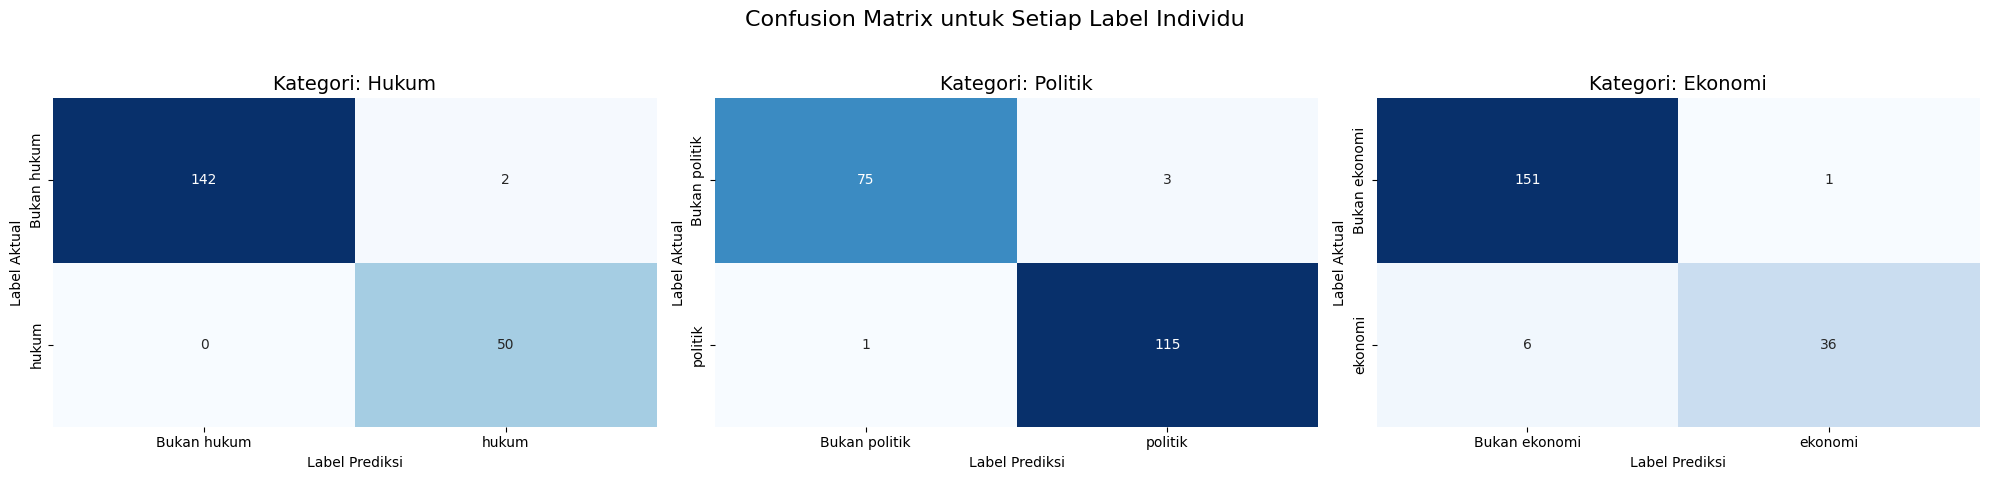



--- Laporan Evaluasi Berdasarkan 7 Kombinasi Label (Format Tabel) ---


,precision,recall,f1-score,support
ekonomi,0.92,0.92,0.92,13.00
hukum,0.91,1.00,0.95,21.00
hukum-ekonomi,1.00,0.25,0.40,4.00
hukum-politik,0.95,1.00,0.97,18.00
hukum-politik-ekonomi,0.67,0.86,0.75,7.00
lainnya,0.95,0.92,0.94,40.00
politik,0.95,0.99,0.97,73.00
politik-ekonomi,1.00,0.78,0.88,18.00
accuracy,0.93,0.93,0.93,0.93
macro avg,0.92,0.84,0.85,194.00



📈 Confusion Matrix (Berdasarkan 7 Kombinasi Label):


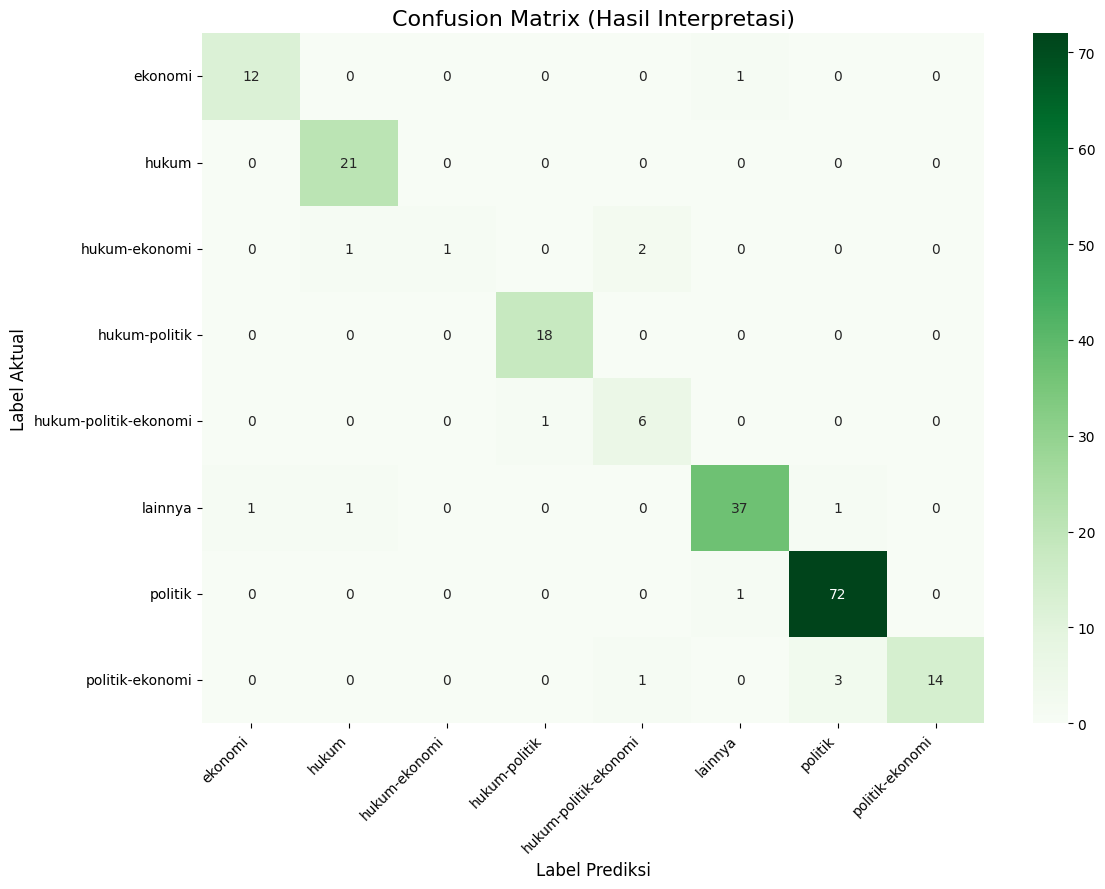

In [8]:
# @title 7. Evaluasi Model (Laporan Lengkap dengan Semua Confusion Matrix)



# Langkah 1 & 2: Prediksi dan konversi ke biner
y_pred_proba = model_kfold.predict(X_test_pad)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# --- Evaluasi Metrik Multilabel Standar ---
print("--- Laporan Evaluasi Model Multilabel ---")
subset_accuracy = accuracy_score(y_test, y_pred_binary)
print(f"🎯 Subset Accuracy (Kecocokan Penuh): {subset_accuracy:.4f}")

hamming = hamming_loss(y_test, y_pred_binary)
print(f"🔻 Hamming Loss (Rata-rata Kesalahan per Label): {hamming:.4f}")

# --- Skor ROC-AUC ---
print("\n--- Skor ROC-AUC (Per Label & Rata-rata) ---")
try:
    roc_auc_macro = roc_auc_score(y_test, y_pred_proba, average='macro')
    roc_auc_weighted = roc_auc_score(y_test, y_pred_proba, average='weighted')
    print(f"📈 ROC-AUC (Macro Average): {roc_auc_macro:.4f}")
    print(f"📈 ROC-AUC (Weighted Average): {roc_auc_weighted:.4f}\n")
    print("Skor ROC-AUC per Label:")
    for i, label in enumerate(labels):
        roc_label = roc_auc_score(y_test[:, i], y_pred_proba[:, i])
        print(f"   - {label.capitalize():<10}: {roc_label:.4f}")
except ValueError:
    print("Tidak dapat menghitung ROC-AUC.")

# --- Laporan Klasifikasi per Label ---
print("\n--- Laporan Klasifikasi (Per Label Individu) ---")
print(classification_report(y_test, y_pred_binary, target_names=labels, zero_division=0))


# --- KODE BARU UNTUK CONFUSION MATRIX PER LABEL INDIVIDU ---
print("\n--- Confusion Matrix (Per Label Individu) ---")
cm_per_label = multilabel_confusion_matrix(y_test, y_pred_binary)

fig, axes = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Confusion Matrix untuk Setiap Label Individu', fontsize=16)

for i, (matrix, label) in enumerate(zip(cm_per_label, labels)):
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', ax=axes[i], cbar=False,
                xticklabels=[f'Bukan {label}', label],
                yticklabels=[f'Bukan {label}', label])
    axes[i].set_title(f'Kategori: {label.capitalize()}', fontsize=14)
    axes[i].set_ylabel('Label Aktual')
    axes[i].set_xlabel('Label Prediksi')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
# --- AKHIR DARI KODE BARU ---


# --- Interpretasi menjadi 7 Kombinasi untuk Laporan Tabel ---
def interpret_binary_to_string_label(binary_predictions):
    label_map = {
        (1, 0, 0): "hukum", (0, 0, 1): "ekonomi", (0, 1, 0): "politik",
        (1, 0, 1): "hukum-ekonomi", (1, 1, 0): "hukum-politik",
        (0, 1, 1): "politik-ekonomi", (1, 1, 1): "hukum-politik-ekonomi",
        (0, 0, 0): "lainnya"
    }
    final_labels = [label_map.get(tuple(pred), "lainnya") for pred in binary_predictions]
    return np.array(final_labels)

# (Sisa kode untuk laporan kombinasi dan confusion matrix kombinasi tidak perlu diubah)
y_pred_combination = interpret_binary_to_string_label(y_pred_binary)
y_true_combination = interpret_binary_to_string_label(y_test)
all_possible_classes = sorted(list(set(y_true_combination) | set(y_pred_combination)))

print("\n\n--- Laporan Evaluasi Berdasarkan 7 Kombinasi Label (Format Tabel) ---")
report_dict = classification_report(y_true_combination, y_pred_combination, labels=all_possible_classes, zero_division=0, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
display(report_df.round(2))

print("\n📈 Confusion Matrix (Berdasarkan 7 Kombinasi Label):")
cm_combination = confusion_matrix(y_true_combination, y_pred_combination, labels=all_possible_classes)
plt.figure(figsize=(12, 9))
sns.heatmap(cm_combination, annot=True, fmt='d', cmap='Greens',
            xticklabels=all_possible_classes, yticklabels=all_possible_classes)
plt.title('Confusion Matrix (Hasil Interpretasi)', fontsize=16)
plt.ylabel('Label Aktual', fontsize=12)
plt.xlabel('Label Prediksi', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [9]:
# Konversi Model
# Simpan Model Keras yang sudah dilatih
# from pickle import pickle



model_kfold.save("bilstm_model_hpe.keras")
print("Model telah disimpan sebagai 'bilstm_model.keras'")

# Simpan Tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
print("Tokenizer telah disimpan sebagai 'tokenizer.pickle'")
    
# Simpan daftar stopwords
with open('stopwords.pickle', 'wb') as handle:
    pickle.dump(all_stopwords, handle)
print("Daftar stopwords telah disimpan sebagai 'stopwords.pickle'")

# Simpan variabel MAX_LEN
with open('max_len.pickle', 'wb') as handle:
    pickle.dump(MAX_LEN, handle)
print(f"MAX_LEN ({MAX_LEN}) telah disimpan sebagai 'max_len.pickle'")

print("\nSemua komponen yang diperlukan telah disimpan!")


Model telah disimpan sebagai 'bilstm_model.keras'
Tokenizer telah disimpan sebagai 'tokenizer.pickle'
Daftar stopwords telah disimpan sebagai 'stopwords.pickle'
MAX_LEN (200) telah disimpan sebagai 'max_len.pickle'

Semua komponen yang diperlukan telah disimpan!


Membuat word cloud untuk setiap label...


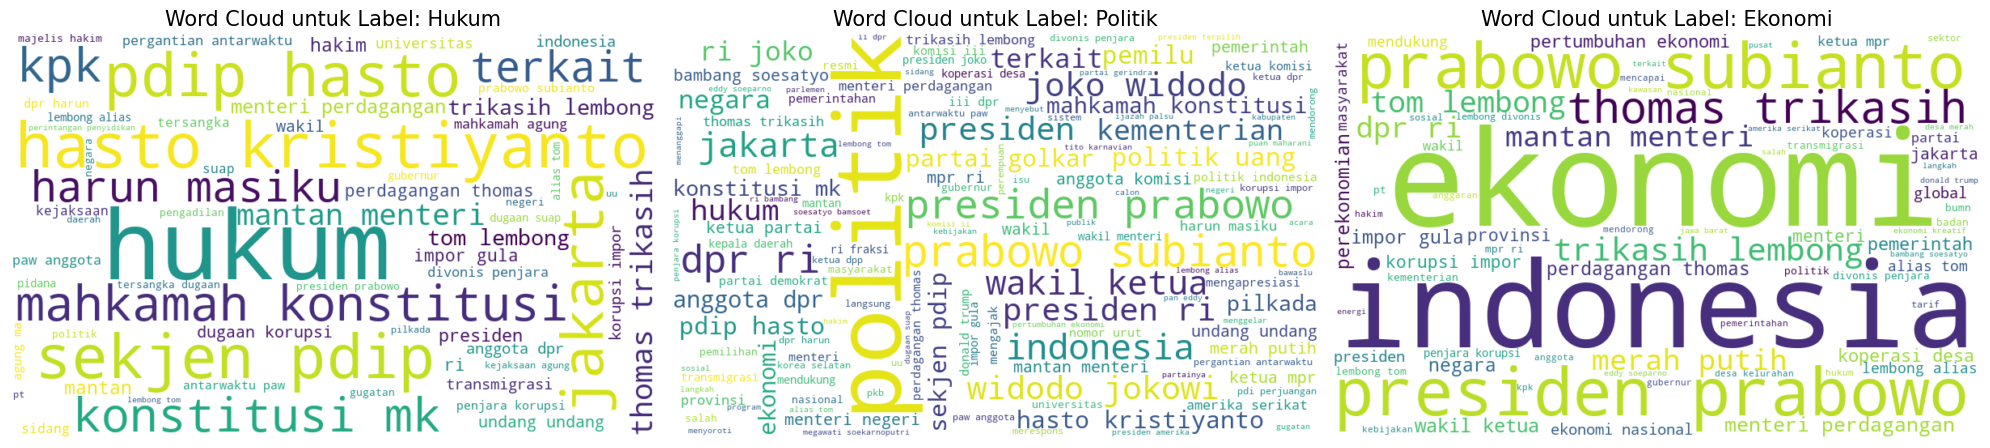

In [10]:
# @title Bonus: Visualisasi Word Cloud per Label



# Pastikan DataFrame 'df' dengan kolom 'cleaned_konten' dan kolom label sudah tersedia

# Daftar label yang ingin dibuatkan word cloud
labels_to_visualize = ['hukum', 'politik', 'ekonomi']

print("Membuat word cloud untuk setiap label...")

# Atur layout plot agar bisa menampilkan beberapa gambar sekaligus
fig, axes = plt.subplots(1, len(labels_to_visualize), figsize=(20, 6))

for i, label in enumerate(labels_to_visualize):
    # 1. Filter teks yang hanya memiliki label yang bersangkutan
    # Ambil semua baris di mana kolom label ini bernilai 1
    text_for_label = df[df[label] == 1]['cleaned_konten']
    
    # 2. Gabungkan semua baris teks menjadi satu string panjang
    long_string = ' '.join(text_for_label)
    
    # 3. Buat objek WordCloud
    wordcloud = WordCloud(width=800, 
                          height=500, 
                          background_color='white', 
                          colormap='viridis',
                          min_font_size=10).generate(long_string)
    
    # 4. Tampilkan gambar menggunakan matplotlib
    ax = axes[i]
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f'Word Cloud untuk Label: {label.capitalize()}', fontsize=15)
    ax.axis('off') # Hilangkan sumbu x dan y

plt.tight_layout()
plt.show()